In [1]:
%load_ext rpy2.ipython

In [ ]:
import scprep

In [2]:
def lizard_brain(number_of_branches_minus_2 = 10,
                 dimension = 10, 
                 epsilon = 0.005, 
                 add_noise = 0.001, 
                 min_branch_points = 50, 
                 k_forknngraph = 8, 
                 make_knn_graph = False,
                 show_fig = False,
                 verbose = False,
                 color_branch_split = False,
                 noise_type = 'uniform'
                ):
    x0 = np.zeros((1,dimension)) 
    i1 = 0 
    i2 = 1 
    branch_links = []
    branch = [] 
    while len(branch)<min_branch_points:
        x0[:,i1] = np.random.random() 
        x0[:,i2] = np.random.random() 
        branch = make_branch(x0,i1,i2,epsilon) 

    data = branch 
    irx = [1]*len(data)

    k = 0 
    while k<=number_of_branches_minus_2:
        n = np.floor(len(branch)/2) 
        #x0 = branch(n,:) 
        start = int(np.floor(np.random.random()*(len(data)-1)))
        x0 = data[[start]]

        i1 = int(np.floor(np.random.random()*dimension)) 
        i2 = int(np.floor(np.random.random()*dimension)) 

        while (i2==i1):
            i2 = int(np.floor(np.random.random()*dimension)) 
        
        if verbose:
            print('Branching in Dim (%i,%i)'%(i1,i2))

        newbranch = make_branch(x0,i1,i2,epsilon) 
        n1 = len(data) 
        n2 = len(newbranch) 

        if color_branch_split:
            if n2>min_branch_points-1:
                data = np.concatenate((data,newbranch)) 
                irx = list(irx)
                irx.extend([k+2]*n2)
                irx = np.array(irx)
                irx[start:np.max(np.where(irx==irx[start]))+1]=(number_of_branches_minus_2+3)+k
                branch = newbranch 
                k = k+1 
        else:
            if n2>min_branch_points-1:
                branch_links.append([irx[start],k+2])
                data = np.concatenate((data,newbranch)) 
                irx.extend([k+2]*n2)
                branch = newbranch 
                k = k+1

        # plot(branch(:,1),branch(:,2),'ko')  hold on 
        # plot([x0(:,1) x0(:,1)+v1(:,1)/20],[x0(:,2) x0(:,2)+v1(:,2)/20],'b-') 
        # plot([x0(:,1) x0(:,1)+v2(:,1)/20],[x0(:,2) x0(:,2)+v2(:,2)/20],'b-') 

    if add_noise>0:
        if noise_type=='uniform':
            data = data + np.random.random((len(data),data.shape[1]))*add_noise 
        if noise_type=='gaussian':
            data = data + np.random.normal(0,1,(len(data),data.shape[1]))*add_noise
        if noise_type=='laplacian':
            data = data + np.random.laplace(0,1,(len(data),data.shape[1]))*add_noise

    pca = PCA()
    u = pca.fit_transform(data)
    v = pca.components_.T
    s = pca.explained_variance_
    if show_fig:
        plt.plot(u[:,1],u[:,2],'ko')  
        plt.xlabel('PC1 : '+str(np.around(s[0]/sum(s)*100,2)))
        plt.ylabel('PC2 : '+str(np.around(s[1]/sum(s)*100,2)))
        plt.show()
    if make_knn_graph:

        knngraph, _ = knnsearch(data,data,k_forknngraph) 
        with open('knn1.sif','w')  as fid:
            for i in range(len(knngraph)):
                for k in range(knngraph.shape[1]):
                    fid.write('%i\tna\t%i\n'%(knngraph[i,0],knngraph[i,k])) 
                    plt.plot([u[knngraph[i,0],0], u[knngraph[i,k],0]],[u[knngraph[i,0],1], u[knngraph[i,k],1]],'b--') 

        plt.show()
    return [data,np.array(irx),v,u,s,branch_links]

def make_branch(x0,i1,i2,epsilon):
    dimension = x0.shape[1] 
    v1 = np.zeros((1,dimension)) 
    v2 = np.zeros((1,dimension)) 
    v1[:,i1] = np.random.random()-0.5  
    v1[:,i2] = np.random.random()-0.5  
    v1 = v1/np.linalg.norm(v1) 
    v2[:,i1] = -v1[:,i2]  
    v2[:,i2] = v1[:,i1] 
    return parabolic_branch(x0,v1,v2,epsilon,dimension) 

def parabolic_branch(x0,v1,v2,epsilon,dimension):
    x = np.zeros((1,dimension)) 
    t = epsilon/1000 
    i = 0
    irx1 = np.where(v1!=0)[1] 
    irx2 = np.where(v2!=0)[1] 
    while 1:
        xn = x0+t*v1+t*t*v2 
        if (np.max(xn[:,irx1])<1) and (np.min(xn[:,irx2])>0):
            if i == 0:
                x = xn
                i = i+1 
                t = t+epsilon
            else:
                x = np.concatenate((x,xn))
                i = i+1 
                t = t+epsilon 
        else:
            break
    return x

In [4]:
%%R
if (!requireNamespace("BiocManager", quietly=TRUE))
    install.packages("BiocManager")
BiocManager::install("splatter", build_vignettes=TRUE)
BiocManager::install("Rhdf5lib")
BiocManager::install("Oshlack/splatter", dependencies = TRUE,build_vignettes = TRUE)
# also install dynverse

R[write to console]: Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

R[write to console]: Installing package(s) 'splatter'

R[write to console]: also installing the dependencies ‘rhdf5’, ‘Rhdf5lib’, ‘HDF5Array’, ‘DelayedMatrixStats’, ‘scater’


R[write to console]: trying URL 'https://bioconductor.org/packages/3.10/bioc/src/contrib/rhdf5_2.30.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 834814 bytes (815 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

In [15]:
%%R
library(splatter)
browseVignettes("splatter")

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find

R[write to console]: Coloring by milestone

R[write to console]: Using milestone_percentages from trajectory



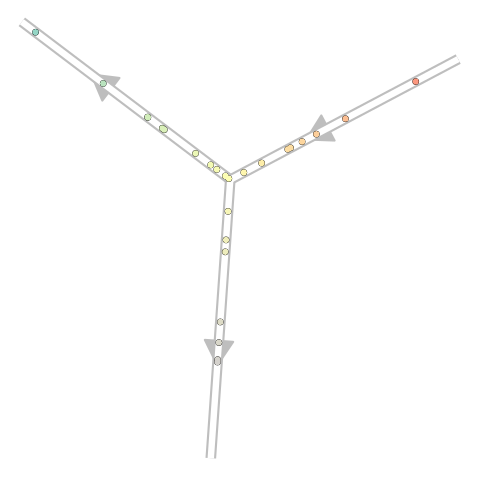

In [6]:
%%R 
library(dynwrap)
library(tibble)
dataset <- wrap_data(cell_ids = letters)

branch_network <- tibble(from = c("A", "A"), to = c("B", "C"))
branch_network


branches <- tibble(branch_id = c("A", "B", "C"), length = 1, directed = TRUE)
branches


branch_progressions <- tibble(
  cell_id = dataset$cell_ids,
  branch_id = sample(branches$branch_id, length(dataset$cell_ids), replace = TRUE),
  percentage = runif(length(dataset$cell_ids))
)
branch_progressions


trajectory <- add_branch_trajectory(
  dataset,
  branch_network,
  branches,
  branch_progressions
)


dynplot::plot_graph(trajectory)

R[write to console]: Getting parameters...

R[write to console]: Creating simulation object...

R[write to console]: Simulating library sizes...

R[write to console]: Simulating gene means...

R[write to console]: Simulating BCV...

R[write to console]: Simulating counts...

R[write to console]: Simulating dropout (if needed)...

R[write to console]: Done!

R[write to console]: Warning in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE,  :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.

R[write to console]: Warning in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE,  :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.

R[write to console]: Warning in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE,  :
R[write to console]: 
 
R[wr

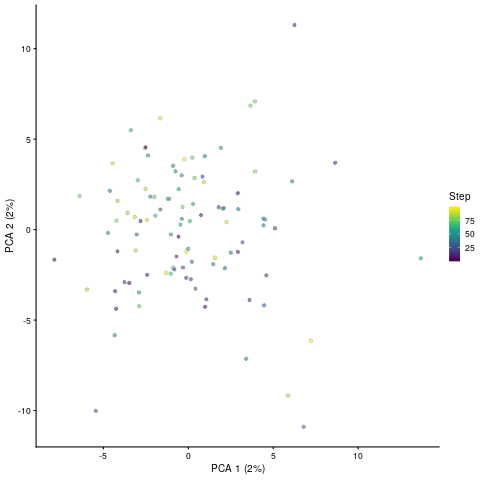

In [28]:
%%R
# https://bioconductor.org/packages/devel/bioc/vignettes/splatter/inst/doc/splatter.html

library(splatter)
library(scater)
set.seed(1)
sce <- mockSCE()

params <- newSplatParams()

params <- setParams(params, update = list(nGenes = 8000, mean.rate = 0.5,de.prob = 0.2))
# Extract multiple parameters as a list
getParams(params, c("nGenes", "mean.rate", "mean.shape"))
      

                    
sim <- splatSimulate(params, nGenes = 1000) 
# Use scater to calculate logcounts
sim <- logNormCounts(sim)
# Plot PCA
sim <- runPCA(sim)
plotPCA(sim)



sim.groups <- splatSimulate(group.prob = c(0.5, 0.5), method = "groups",
                            verbose = FALSE)
sim.groups <- logNormCounts(sim.groups)
sim.groups <- runPCA(sim.groups)



plotPCA(sim.groups, colour_by = "Group")

sim.paths <- splatSimulate(method = "paths", verbose = FALSE)
sim.paths <- logNormCounts(sim.paths)
sim.paths <- runPCA(sim.paths)

plotPCA(sim.paths, colour_by = "Step")